<a href="https://colab.research.google.com/github/dfu5823/ONM-Outcomes/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title
# final_features = [
#     'AGE', # keep this, allow user to enter "Age"
#     'CROWFLY', # keep this, allow user to enter "Patient's residence distance from nearest hospital in miles (estimate is okay)"
#     'REGIONAL_NODES_POSITIVE', # keep this, allow user to enter "Number of positive regional nodes"
#     'TUMOR_SIZE_SUMMARY_16', # remove this... it's just one-hot encoding of tumor size
#     'TUMOR_SIZE', # keep this, allow user to enter "Tumor Size (size of largest dimension in mm)"
#     'DX_SURG_STARTED_DAYS', # keep this, allow user to enter "Number of days from diagnosis to first surgical procedure"
#     'DX_DEFSURG_STARTED_DAYS', # keep this, allow user to enter "Number of days from diagnosis to definitive surgical resection of primary site"
#     'SURG_DISCHARGE_DAYS', # keep this, allow user to enter "Number of days from surgery to discharge"
#     'REGIONAL_NODES_EXAMINED', # keep this, allow user to enter "Number of regional nodes examined"
#     'NO_HSD_QUAR_00', # remove this... it's the percentage of people in the census tract with no high school diploma in 2000
#     'NO_HSD_QUAR_2016', # remove this... it's the percentage of people in the census tract with no high school diploma in 2016
#     'UR_CD_03', # remove this... it's the urban-rural classification of the census tract
#     'CDCC_TOTAL_BEST', # keep this, allow user to select from a dropdown list "Charlson/Deyo comorbidity score", see note below
#     'SEX_1.0', # keep this, allow user to select from M or F or other, M means SEX_1.0 is positive, F means negative, other means leave it blank
#     'FACILITY_TYPE_CD_nan', # remove this... it's just one-hot encoding of facility type left blank
#     'FACILITY_LOCATION_CD_2.0', # keep this, user should select state from a dropdown, see note on facility location below 'FACILITY_LOCATION_CD_5.0', # see note on facility location below
#     'FACILITY_LOCATION_CD_nan', # see note on facility location below
#     'PUF_MULT_SOURCE_0', # keep this, allow user to select from two options "Was the patient treated at multiple CoC-accredited (Commission of Cancer) facilities", see note below
#     'PUF_MULT_SOURCE_1', # keep this, same as above, if user selects "Yes", this will be 1, if "No", this will be 0
#     'INSURANCE_STATUS_1.0', # keep this, user should select patient insurance from a dropdown, see note below
#     'INSURANCE_STATUS_3.0', # see note below
#     'PUF_MEDICAID_EXPN_CODE_9.0', # remove this
#     'SEQUENCE_NUMBER_1.0', # keep this, allow user to enter "How many primary cancers has the patient had before this current HNSCC primary" and use the answer to map to a code, see note below
#     'SEQUENCE_NUMBER_2.0', # same as above
#     'CLASS_OF_CASE_10', # remove this... it's just one-hot encoding of class of case, indicating whether or not to treat at this facility
#     'CLASS_OF_CASE_13', # remove this... it's just one-hot encoding of class of case
#     'CLASS_OF_CASE_14', # remove this... it's just one-hot encoding of class of case
#     'CLASS_OF_CASE_21', # remove this... it's just one-hot encoding of class of case
#     'CLASS_OF_CASE_22', # remove this... it's just one-hot encoding of class of case
#     'PRIMARY_SITE_C019', # remove this... it's just one-hot encoding of primary site
#     'PRIMARY_SITE_C079', # remove this... it's just one-hot encoding of primary site
#     'GRADE_3.0', # keep this, allow user to select from a dropdown list "Tumor Grade", see note below
#     'TNM_CLIN_T_ c1', # keep this, allow user to select from a dropdown list "Clinical T stage", see note below
#     'TNM_CLIN_STAGE_GROUP_ 1', # keep this, allow user to select from a dropdown list "Clinical Stage Group", see note below
#     'TNM_CLIN_STAGE_GROUP_ 4A', # same as above
#     'TNM_PATH_T_ p1', # keep this, allow user to select from a dropdown list "Pathological T stage", see note below
#     'TNM_PATH_T_ p2', # same as above
#     'TNM_PATH_T_ p4A', # same as above
#     'TNM_PATH_N_ p0', # keep this, allow user to select from a dropdown list "Pathological N stage", see note below
#     'TNM_PATH_M_ pX', # keep this, allow user to select from a dropdown list "Pathological M stage", see note below
#     'ANALYTIC_STAGE_GROUP_1', # keep this, allow user to select from a dropdown list "Overall AJCC Stage Group", see note below
#     'CS_EXTENSION_100.0', # remove this... it's just one-hot encoding of CS extension which is a deprecated variable
#     'CS_EXTENSION_300.0', # remove this... it's just one-hot encoding of CS extension which is a deprecated variable
#     'CS_EXTENSION_535.0', # remove this... it's just one-hot encoding of CS extension which is a deprecated variable
#     'RX_HOSP_SURG_PRIM_SITE_0.0', # remove this... it's just one-hot encoding of the primary surgical procedure
#     'RX_HOSP_SURG_PRIM_SITE_42.0', # remove this... it's just one-hot encoding of the primary surgical procedure
#     'RX_HOSP_SURG_APPR_2010_1.0', # keep this, allow user to select from a dropdown list "Surgical approach for primary site", see note below
#     'RX_HOSP_SURG_APPR_2010_5.0', # same as above
#     'LN_SIZE_0.0', # remove this... it's just one-hot encoding of a deprecated variable
#     'CS_SITESPECIFIC_FACTOR_4_0.0', # remove this... it's just one-hot encoding of a deprecated variable
#     'HISTOLOGY_8071.0', # remove this... it's just one-hot encoding of histology
#     'CS_SITESPECIFIC_FACTOR_9_10.0', # remove this... it's just one-hot encoding of a deprecated variable
#     'CS_SITESPECIFIC_FACTOR_9_988.0', # remove this... it's just one-hot encoding of a deprecated variable
#     'CS_SITESPECIFIC_FACTOR_11_999', # remove this... it's just one-hot encoding of a deprecated variable
#     'CS_SITESPECIFIC_FACTOR_10_988.0', # remove this... it's just one-hot encoding of a deprecated variable
#     'CS_SITESPECIFIC_FACTOR_10_998.0'# remove this... it's just one-hot encoding of a deprecated variable
#     ]

#     """
#     CDCC_TOTAL_BEST Code Definition 0 Total Charlson-Deyo Score of 0 1 Total Charlson-Deyo Score of 1 2 Total Charlson-Deyo Score of 2 3 Total Charlson-Deyo Score of 3 or more Charlson-Deyo Comorbidity Score Mapping Table Condition Charlson-Deyo Score* Myocardial Infarction 1 Congestive Heart Failure 1 Peripheral VascularDisease 1 CerebrovascularDisease 1 Dementia 1 Chronic Pulmonary Disease 1 RheumatologicDisease 1 Peptic Ulcer Disease 1 Mild Liver Disease 1 Diabetes 1 Diabetes with Chronic Complications 2 Hemiplegia or Paraplegia 2 Renal Disease 2 Moderate or Severe Liver Disease 3 AIDS 6
#     """

#     """
#     FACILITY_LOCATION_CD Code Definition State Grouping 1 New England CT, MA, ME, NH, RI, VT 2 Middle Atlantic NJ, NY, PA 3 South Atlantic DC, DE, FL, GA, MD, NC, SC, VA, WV 4 East North Central IL, IN, MI, OH, WI 5 East South Central AL, KY, MS, TN 6 West North Central IA, KS, MN, MO, ND, NE, SD 7 West South Central AR, LA, OK, TX 8 Mountain AZ, CO, ID, MT, NM, NV, UT, WY 9 Pacific AK, CA, HI, OR, WA blank Not available Not available
#     """

#     """
#     INSURANCE_STATUS Code Definition 0 Not Insured 1 Private Insurance / Managed Care 2 Medicaid 3 Medicare 4 Other Government 9 Insurance Status Unknown
#     """

#     """
#     SEQUENCE_NUMBER Code Definition Type of Primaries 00 One malignant or in situ primary only in the patient’s lifetime Malignant or In Situ 01 First of two or more independent malignant or in situ primaries Malignant or In Situ 02 Second of two or more independent malignant or in situ primaries Malignant or In Situ … Malignant or In Situ … (Actual sequence of this malignant or in situ primary) Malignant or In Situ … Malignant or In Situ 59 Fifty-ninth of 59 or more independent malignant or in situ primaries Malignant or In Situ 60 One nonmalignant primary only in the patient’s lifetime Non-Malignant 61 First of two or more independent nonmalignant primaries Non-Malignant 62 Second of two or more independent nonmalignant primaries Non-Malignant … Non-Malignant … (Actual sequence of this nonmalignant primary) Non-Malignant … Non-Malignant 87 Twenty-seventh of 27 or more independent nonmalignant primaries Non-Malignant 88 Unspecified number of independent nonmalignant primaries Non-Malignant 99 Unknown number of malignant or in situ primaries Malignant or In Situ
#     """

#     """
#     GRADE Code Definition Description Specific Cancer Grouping 1 Grade I, 1, i Well differentiated; differentiated, NOS 2 Grade II,2, ii I/III or 1/3 Moderately differentiated; moderately well differentiated; intermediate differentiation 3 Grade III,3, iii II/III or 2/3 Poorly differentiated; dedifferentiated 4 Grade IV,4, iv III/III or 3/3 Undifferentiated; anaplastic 5 T cell; T-precursor Lymphomas and Leukemias 6 B cell; pre-B; B-precursor Lymphomas and Leukemias 7 Null cell; non T-non B Lymphomas and Leukemias 8 NK (natural killer) cell (effective with diagnosis 1/1/95 and after) Lymphomas and Leukemias 9 Cell type not determined, not stated or not applicable; unknown primaries; high grade dysplasia (adenocarcinoma in situ) All histologies
#     """

#     """
#     TNM_CLIN_T Code Definition Code Definition Blank Not available in patient record 2A, c2A cT2a 2A1, c2A1 cT2a1 X, cX cTX 2A2, c2A2 cT2a2 0, c0 cT0 2B, c2B cT2b A, pA pTa 2C, c2C cT2c IS, pIS pTis 2D, c2D cT2d ISPU, pISPU pTispu 3, c3 cT3 ISPD, pISPD pTispd 3A, c3A cT3a 1MI, c1MI cT1mic 3B, c3B cT3b 1, c1 cT1 3C, c3C cT3c 1A, c1A cT1a 3D, c3D cT3d 1A1, c1A1 cT1a1 4, c4 cT4 1A2, c1A2 cT1a2 4A, c4A cT4a 1B, c1B cT1b 4B, c4B cT4b 1B1, c1B1 cT1b1 4C, c4C cT4c 1B2, c1B2 cT1b2 4D, c4D cT4d 1C, c1C cT1c 4E, c4E cT4e 1D, c1D cT1d 88 Not applicable 2, c2 cT2
#     """

#     """
#     TNM_CLIN_STAGE_GROUP Code Definition Code Definition 0 cStage 0 2C cStage IIC 0A cStage 0A 3 cStage III 0IS cStage 0is 3A cStage IIIA 1 cStage I 3B cStage IIIB 1A cStage IA 3C cStage IIIC 1A1 cStage IA1 3C1 cStage IIIC1 1A2 cStage IA2 3C2 cStage IIIC2 1B cStage IB 4 cStage IV 1B1 cStage IB1 4A cStage IVA 1B2 cStage IB2 4A1 cStage IVA1 1C cStage IC 4A2 cStage IVA2 1S cStage IS 4B cStage 4B 2 cStage II 4C cStage IVC 2A cStage IIA OC Occult 2A1 cStage IIA1 88 Not applicable 2A2 cStage IIA2 99 Unknown 2B cStage IIB blank Not available
#     """

#     """
#     TNM_PATH_T Code Definition Code Definition blank Not available in patient record. Not collected (2008+) 2, p2 pT2 2A, p2A pT2a 2A1, p2A1 pT2a1 X, px pTX 2A2, p2A2 pT2a2 0, p0 pT0 2B, p2B pT2b A, pA pTa 2C, p2C pT2c IS, pIS pTis 2D, p2D pT2d ISPU, pISPU pTispu 3, p3 pT3 ISPD, pISPD pTispd 3A, p3A pT3a 1MI, p1MI pT1mic 3B, p3B pT3b 1, p1 pT1 3C, p3C pT3c 1A, p1A pT1a 3D, p3D pT3d 1A1, p1A1 pT1a1 4, p4 pT4 1A2, p1A2 pT1a2 4A, p4A pT4a 1B, p1B pT1b 4B, p4B pT4b 1B1, p1B1 pT1b1 4C, p4C pT4c 1B2, p1B2 pT1b2 4D, p4D pT4d 1C, p1C pT1c 4E, p4E pT4e 1D, p1D pT1d 88 Not applicable
#     """

#     """
#     TNM_PATH_N Code Definition blank Not available in patient record. Not collected (2008+) X pNX 0, p0, c0 pN0, cN0 0I-, p0I- pN0i0I+, p0I+ pN0i+ 0M-, p0M- pN0m0M+, p0M+ pN0m+ 1MI, p1MI pN1mi 0A, p0A pN0a 0B, p0B pN0b 1, p1 pN1 1A, p1A pN1a 1B, p1B pN1b 1C, p1C pN1c 2, p2 pN2 2A, p2A pN2a 2B, p2B pN2b 2C, p2C pN2c 3, p3 pN3 3A, p3A pN3a 3B,p3B pN3b 3C, p3C pN3c 4, p4 pN4 88 Not applicable
#     """

#     """
#     TNM_PATH_M Code Definition* blank Not available in patient record. No positive pM. Not collected (2008+) X, px, cx pMX, cMX 0, p0, c0 pM0, cM0 0I+, p0I+, c0I+ pM0(i+), cM0(i+) 1, p1, c1 pM1, cM1 1A, p1A, c1A pM1a, cM1a 1B, p1B, c1B pM1b, cM1b 1C. p1C, c1C pM1c, cM1c 1D, p1D, c1D pM1d, cM1d 88 Not applicable (not defined)
#     """

#     """
#     ANALYTIC_STAGE_GROUP Code Definition 0 Stage 0 1 Stage I 2 Stage II 3 Stage III 4 Stage IV 5 Occult (lung only) 8 AJCC staging not applicable 9 AJCC stage group unknown
#     """

#     """
#     RX_HOSP_SURG_APPR_2010 Code Definition 0 No surgical procedure of primary site at this facility 1 Robotic assisted 2 Robotic converted to open 3 Minimally invasive (such as endoscopic or laparoscopic) 4 Minimally invasive (endoscopic or laparoscopic) converted to open 5 Open or approach unspecified 9 Unknown whether surgery was performed at this facility blank Not available
#     """

#     # print(f'Final feature list length: {len(final_features)}')

In [2]:
!git clone https://github.com/dfu5823/ONM-Outcomes.git

fatal: destination path 'ONM-Outcomes' already exists and is not an empty directory.


In [3]:
# !pip install -r ONM-Outcomes/requirements.txt
! pip install cloudpickle numpy pandas scikit-learn gradio catboost shap plotly

In [4]:
# Clean notebook formatting for Github

import nbformat
P = "/content/ONM-Outcomes/demo.ipynb"
nb = nbformat.read(P, as_version=4)

widgets = nb.metadata.get("widgets", None)
if isinstance(widgets, dict) and "state" not in widgets:
    nb.metadata.pop("widgets", None)

nb.metadata.pop("colab", None)

nbformat.write(nb, P)
print("Sanitized and saved", P)

Sanitized and saved /content/ONM-Outcomes/demo.ipynb


In [5]:
# Imports and Load Model

# --- core ---
import os, re, io, json, time, warnings, math, zipfile, requests
import numpy as np
import pandas as pd
from typing import Optional, Dict, Tuple
import cloudpickle

# --- model / explainability ---
from sklearn.ensemble import StackingClassifier
import shap
import plotly.graph_objects as go

# --- app ---
import gradio as gr

MODEL_DIR = "ONM-Outcomes/models/"

with open(os.path.join(MODEL_DIR, "30d_mort_demo_trained_stacked_model.pkl"), "rb") as f:
    stacked_model = cloudpickle.load(f)



/tmp/ipython-input-3169734496.py:21: UserWarning: [02:03:55] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  stacked_model = cloudpickle.load(f)


In [6]:
# # Create feature mapping
# ------------------------------- #
# Final feature list (exact order)
# ------------------------------- #
selected_features = [
    'AGE',
    'CROWFLY',
    'YEAR_OF_DIAGNOSIS',
    'REGIONAL_NODES_POSITIVE',
    'TUMOR_SIZE_SUMMARY_16',
    'TUMOR_SIZE',
    'DX_SURG_STARTED_DAYS',
    'DX_DEFSURG_STARTED_DAYS',
    'SURG_DISCHARGE_DAYS',
    'REGIONAL_NODES_EXAMINED',

    # ZIP-derived (auto)
    'NO_HSD_QUAR_00',
    'NO_HSD_QUAR_12',
    'NO_HSD_QUAR_2016',
    'MED_INC_QUAR_00',
    'MED_INC_QUAR_12',
    'MED_INC_QUAR_2016',
    'UR_CD_03',
    'UR_CD_13',

    # Clinico-demographic
    'CDCC_TOTAL_BEST',
    'BEHAVIOR',

    # Race (collapsed to White/Black/Other)
    'RACE_1.0',   # White
    'RACE_2.0',   # Black

    # Sex (two cols per spec)
    'SEX_1.0',  # Male
    'SEX_2.0',  # Female

    # Facility Type (one-hot + nan)
    'FACILITY_TYPE_CD_1.0',
    'FACILITY_TYPE_CD_2.0',
    'FACILITY_TYPE_CD_3.0',
    'FACILITY_TYPE_CD_4.0',
    'FACILITY_TYPE_CD_nan',

    # Clinical Stage Group (you listed both a base token and specific one-hots)
    'TNM_CLIN_STAGE_GROUP_',
    'TNM_CLIN_STAGE_GROUP_   0',
    'TNM_CLIN_STAGE_GROUP_   1',
    'TNM_CLIN_STAGE_GROUP_   2',
    'TNM_CLIN_STAGE_GROUP_   3',
    'TNM_CLIN_STAGE_GROUP_   4',
    'TNM_CLIN_STAGE_GROUP_  4A',
    'TNM_CLIN_STAGE_GROUP_  4B',
    'TNM_CLIN_STAGE_GROUP_  4C',
    'TNM_CLIN_STAGE_GROUP_  99',

    'RACE_OTHER', # All other races collapsed
]

# ------------------------------- #
# Defaults
# ------------------------------- #
default_values = {
    "AGE": 65,
    "CROWFLY": 10.0,
    "YEAR_OF_DIAGNOSIS": 2015,
    "REGIONAL_NODES_POSITIVE": 1,
    "TUMOR_SIZE": 30,                 # mm
    "DX_SURG_STARTED_DAYS": 14,
    "DX_DEFSURG_STARTED_DAYS": 21,
    "SURG_DISCHARGE_DAYS": 5,
    "REGIONAL_NODES_EXAMINED": 10,
    "CDCC_TOTAL_BEST": 0,
    # ZIP-derived defaults if lookup fails (None -> we'll fallback to mid bins)
    "NO_HSD_QUAR_00": 2,
    "NO_HSD_QUAR_12": 2,
    "NO_HSD_QUAR_2016": 2,
    "MED_INC_QUAR_00": 3,
    "MED_INC_QUAR_12": 3,
    "MED_INC_QUAR_2016": 3,
    "UR_CD_03": 2,
    "UR_CD_13": 2,
    # Behavior default (invasive = 3 is typical for cancers captured in NCDB)
    "BEHAVIOR": 3,
}

# ------------------------------- #
# Controlled-value dropdown maps
# ------------------------------- #
RACE_UI_TO_ONEHOT = {
    "White":  ("RACE_1.0",),
    "Black":  ("RACE_2.0",),
    "Other":  ("RACE_OTHER",),
}

SEX_UI_TO_ONEHOT = {
    "M": ("SEX_1.0",),
    "F": ("SEX_2.0",),
    "Other / Unknown": tuple(),  # both 0
}

FACILITY_TYPE_UI_TO_ONEHOT = {
    "Community Cancer Program":               ("FACILITY_TYPE_CD_1.0",),
    "Comprehensive Community Cancer Program": ("FACILITY_TYPE_CD_2.0",),
    "Academic/Research Program":              ("FACILITY_TYPE_CD_3.0",),
    "Integrated Network Cancer Program":      ("FACILITY_TYPE_CD_4.0",),
    "Not available":                          ("FACILITY_TYPE_CD_nan",),
}

CLIN_STAGE_UI_TO_ONEHOT = {
    "Stage 0":   "TNM_CLIN_STAGE_GROUP_   0",
    "Stage 1":   "TNM_CLIN_STAGE_GROUP_   1",
    "Stage 2":   "TNM_CLIN_STAGE_GROUP_   2",
    "Stage 3":   "TNM_CLIN_STAGE_GROUP_   3",
    "Stage 4":   "TNM_CLIN_STAGE_GROUP_   4",
    "Stage 4A":  "TNM_CLIN_STAGE_GROUP_  4A",
    "Stage 4B":  "TNM_CLIN_STAGE_GROUP_  4B",
    "Stage 4C":  "TNM_CLIN_STAGE_GROUP_  4C",
    "Unknown":   "TNM_CLIN_STAGE_GROUP_  99",
}

# Behavior code (0-3) — show descriptive labels to user, map back to code
BEHAVIOR_UI_TO_CODE = {
    "Benign": 0,
    "Borderline / Uncertain": 1,
    "In-situ": 2,
    "Invasive": 3,
}

In [7]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ---- baseline prevalence (given) ----
BASELINE_PREVALENCE = 284 / 32764  # ~0.866%

def odds_ratio_vs_baseline(p: float, p0: float = BASELINE_PREVALENCE) -> float:
    p  = float(np.clip(p,  1e-8, 1 - 1e-8))
    p0 = float(np.clip(p0, 1e-8, 1 - 1e-8))
    return (p / (1 - p)) / (p0 / (1 - p0))

# ---------------------- background loader (pickle + cache) ----------------
_SHAP_BG_CACHE = {"X": None, "path": None}

def load_shap_background(expected_cols, path: str = "ONM-Outcomes/models/shap_background.pkl"):
    """
    Load a precomputed model-ready background matrix from a pickle file
    and align it to expected_cols. No background generation here.
    """
    # cached?
    if _SHAP_BG_CACHE["X"] is not None and _SHAP_BG_CACHE["path"] == path:
        return _SHAP_BG_CACHE["X"].reindex(columns=expected_cols).fillna(0.0)

    if not os.path.exists(path):
        raise FileNotFoundError(
            f"SHAP background pickle not found at '{path}'. "
            f"Please create it (e.g., with pickle.dump(Xbg, open('{path}','wb')))."
        )

    with open(path, "rb") as f:
        Xbg = pickle.load(f)

    # Align & cast numerics to float to avoid dtype warnings
    Xbg = pd.DataFrame(Xbg)  # in case a numpy array was saved
    Xbg = Xbg.reindex(columns=expected_cols).fillna(0.0)
    num_cols = Xbg.select_dtypes(include=[np.number]).columns
    Xbg[num_cols] = Xbg[num_cols].astype(float)

    # Keep small for speed (tweak as you like)
    if len(Xbg) > 500:
        Xbg = Xbg.sample(500, random_state=42)

    _SHAP_BG_CACHE["X"] = Xbg
    _SHAP_BG_CACHE["path"] = path
    return Xbg

# ---------------- feature grouping (for readable bars) --------------------
def build_group_map(feature_cols: list[str]) -> dict[str, list[str]]:
    groups = {
        "ZIP: Education (No HS)": [c for c in feature_cols if c.startswith("NO_HSD_QUAR_")],
        "ZIP: Median Income":     [c for c in feature_cols if c.startswith("MED_INC_QUAR_")],
        "ZIP: Urban/Rural":       [c for c in feature_cols if c.startswith("UR_CD_")],
        "Clinical Stage Group":   [c for c in feature_cols if c.startswith("TNM_CLIN_STAGE_GROUP_")],
        "Race":                   [c for c in feature_cols if c.startswith("RACE_")],
        "Sex":                    [c for c in feature_cols if c.startswith("SEX_")],
        "Facility Type":          [c for c in feature_cols if c.startswith("FACILITY_TYPE_CD_")],
        "Regional Nodes (pos/exam)": [c for c in feature_cols if c in ("REGIONAL_NODES_POSITIVE", "REGIONAL_NODES_EXAMINED")],
        "Timing (Dx→Surg/DefSurg/Discharge)": [
            c for c in feature_cols if c in ("DX_SURG_STARTED_DAYS", "DX_DEFSURG_STARTED_DAYS", "SURG_DISCHARGE_DAYS")
        ],
        "Tumor Size":             [c for c in feature_cols if c in ("TUMOR_SIZE", "TUMOR_SIZE_SUMMARY_16")],
        "Age":                    ["AGE"],
        "Distance to Hospital":   ["CROWFLY"],
        "Year of Diagnosis":      ["YEAR_OF_DIAGNOSIS"],
        "Charlson/Deyo":          ["CDCC_TOTAL_BEST"],
        "Behavior":               ["BEHAVIOR"],
    }
    # Show any stray columns individually
    used = set(sum(groups.values(), []))
    for c in feature_cols:
        if c not in used:
            groups[c] = [c]
    return groups

# --------------- SHAP (KernelExplainer) on the calibrated stacker --------
def shap_grouped_bar_kernel(model, df_row: pd.DataFrame, bg_pickle_path: str = "shap_background.pkl", max_display=12):
    """
    Pure black-box SHAP on your calibrated stacked model (no XGBoost references).
    Uses ONLY the precomputed pickle background (no on-the-fly generation).
    """
    assert isinstance(df_row, pd.DataFrame) and len(df_row) == 1, "df_row must be a 1-row DataFrame"
    cols = list(df_row.columns)

    # Load & align background from pickle
    Xbg = load_shap_background(cols, path=bg_pickle_path)
    if len(Xbg) > 256:  # extra speed guard
        Xbg = Xbg.sample(256, random_state=42)

    # Probability function
    def proba_fn(x):
        Xdf = pd.DataFrame(x, columns=cols)
        return model.predict_proba(Xdf)[:, 1]

    # Kernel SHAP on log-odds
    explainer = shap.KernelExplainer(proba_fn, Xbg, link="logit")
    sv = explainer.shap_values(df_row, nsamples="auto")
    shap_vals = np.asarray(sv)
    if shap_vals.ndim == 2 and shap_vals.shape[0] == 1 and shap_vals.shape[1] == len(cols):
        shap_vals = shap_vals[0]
    else:
        raise ValueError(f"Unexpected SHAP shape {shap_vals.shape}, expected (1, {len(cols)})")

    # Group to user-level concepts
    group_map = build_group_map(cols)
    sv_series = pd.Series(shap_vals, index=cols)
    grouped = {g: float(sv_series[v].sum()) for g, v in group_map.items() if any(c in cols for c in v)}

    # Top impacts
    imp = pd.Series(grouped).abs().sort_values(ascending=False)
    top = imp.head(max_display).index

    fig, ax = plt.subplots(figsize=(8, 5))
    signed = pd.Series(grouped)[top]
    ax.barh(range(len(top)), signed.values)
    ax.set_yticks(range(len(top)))
    ax.set_yticklabels(top)
    ax.set_xlabel("SHAP value (impact on log-odds)")
    ax.set_title("What drove this prediction?")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    return fig


In [8]:
# Census data helpers

# ------------------------------- #
# Census / RUCC helpers (ZIP → 8 vars)
# ------------------------------- #
CENSUS_BASE = "https://api.census.gov/data"
CENSUS_API_KEY = os.environ.get("CENSUS_API_KEY", None)  # optional

def _get(url: str, params: dict, tries: int = 3, sleep: float = 0.7):
    for _ in range(tries):
        r = requests.get(url, params=params, timeout=30)
        if r.ok:
            return r
        time.sleep(sleep)
    r.raise_for_status()

def _as_float(x) -> Optional[float]:
    if x is None:
        return None
    s = str(x)
    m = re.search(r"[-+]?\d+(\.\d+)?", s)
    return float(m.group(0)) if m else None

def _zip_to_zcta(zip5: str) -> str:
    if not re.fullmatch(r"\d{5}", zip5):
        raise ValueError("ZIP must be 5 digits.")
    return zip5

def _hud_zip_county_crosswalk() -> pd.DataFrame:
    url = "https://www.huduser.gov/portal/datasets/usps_crosswalk.html"
    html = requests.get(url, timeout=30).text
    m = re.search(r'href="([^"]+zip_county[^"]+\.csv)"', html, flags=re.I)
    if not m:
        raise RuntimeError("Could not locate HUD ZIP–County CSV link.")
    csv_url = m.group(1)
    if csv_url.startswith("/"):
        csv_url = "https://www.huduser.gov" + csv_url
    df = pd.read_csv(csv_url, dtype={"ZIP": str, "COUNTY": str})
    keep = [c for c in ["ZIP", "COUNTY", "RES_RATIO"] if c in df.columns]
    return df[keep]

def _dominant_county_for_zip(zip5: str) -> str:
    xw = _hud_zip_county_crosswalk()
    sub = xw[xw["ZIP"] == zip5]
    if sub.empty:
        sub = xw[xw["ZIP"] == str(int(zip5)).zfill(5)]
    if sub.empty:
        raise ValueError(f"No county mapping found for ZIP {zip5}")
    row = sub.sort_values("RES_RATIO", ascending=False).iloc[0]
    return row["COUNTY"]  # 5-digit county FIPS

def _load_rucc_2003_2013() -> pd.DataFrame:
    url = ("https://seer.cancer.gov/seerstat/variables/countyattribs/"
           "Rural.Urban.Continuum.Codes.1974.1983.1993.2003.2013.2023.xlsx")
    data = requests.get(url, timeout=60).content
    df = pd.read_excel(io.BytesIO(data), engine="openpyxl", dtype={"FIPS": str})
    cols = {c: c for c in df.columns}
    for c in list(df.columns):
        lc = c.lower()
        if "rural-urban continuum code 2003" in lc:
            cols[c] = "RUCC_2003"
        if "rural-urban continuum code 2013" in lc:
            cols[c] = "RUCC_2013"
    df = df.rename(columns=cols)
    need = ["FIPS", "RUCC_2003", "RUCC_2013"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise RuntimeError(f"RUCC columns missing: {missing}")
    df["FIPS"] = df["FIPS"].str.zfill(5)
    return df[need]

def _rucc_for_county(county_fips: str) -> Tuple[Optional[int], Optional[int]]:
    rucc = _load_rucc_2003_2013()
    row = rucc[rucc["FIPS"] == county_fips]
    if row.empty:
        return None, None
    r = row.iloc[0]
    v03 = int(r["RUCC_2003"]) if not pd.isna(r["RUCC_2003"]) else None
    v13 = int(r["RUCC_2013"]) if not pd.isna(r["RUCC_2013"]) else None
    return v03, v13

# Education → quartiles
def _edu_quartile_2000(percent_no_hs: float) -> int:
    if percent_no_hs >= 29.0: return 1
    if percent_no_hs >= 20.0: return 2
    if percent_no_hs >= 14.0: return 3
    return 4

def _edu_quartile_2012(percent_no_hs: float) -> int:
    if percent_no_hs >= 21.0: return 1
    if percent_no_hs >= 13.0: return 2
    if percent_no_hs >= 7.0:  return 3
    return 4

def _edu_quartile_2016(percent_no_hs: float) -> int:
    if percent_no_hs >= 17.6: return 1
    if percent_no_hs >= 10.9: return 2
    if percent_no_hs >= 6.3:  return 3
    return 4

# Income → quartiles
def _inc_quartile_2000(median_income_1999_usd: float) -> int:
    if median_income_1999_usd < 30000: return 1
    if median_income_1999_usd <= 34999: return 2
    if median_income_1999_usd <= 45999: return 3
    return 4

def _inc_quartile_2012(median_income_2012usd: float) -> int:
    if median_income_2012usd < 38000: return 1
    if median_income_2012usd <= 47999: return 2
    if median_income_2012usd <= 62999: return 3
    return 4

def _inc_quartile_2016(median_income_2016usd: float) -> int:
    if median_income_2016usd < 40227: return 1
    if median_income_2016usd <= 50353: return 2
    if median_income_2016usd <= 63332: return 3
    return 4

# Census pulls
def _edu_pct_no_hs_2000(zcta: str) -> Optional[float]:
    url = f"{CENSUS_BASE}/2000/dec/sf3profile"
    # Try numeric cell, then labeled cell
    for var in ["DP2_C28A0", "DP2_E1"]:
        try:
            params = {"get": var, "for": f"zip%20code%20tabulation%20area:{zcta}"}
            if CENSUS_API_KEY: params["key"] = CENSUS_API_KEY
            r = _get(url, params=params)
            vals = r.json()[1][0]
            pct_hs_plus = _as_float(vals)
            if pct_hs_plus is not None:
                return max(0.0, 100.0 - pct_hs_plus)
        except Exception:
            continue
    return None

def _edu_pct_no_hs_acs(zcta: str, vintage: int) -> Optional[float]:
    url = f"{CENSUS_BASE}/{vintage}/acs/acs5/profile"
    params = {"get": "DP02_0067PE", "for": f"zip%20code%20tabulation%20area:{zcta}"}
    if CENSUS_API_KEY: params["key"] = CENSUS_API_KEY
    r = _get(url, params=params)
    pct_hs_plus = _as_float(r.json()[1][0])
    return max(0.0, 100.0 - pct_hs_plus) if pct_hs_plus is not None else None

def _median_income_2000(zcta: str) -> Optional[float]:
    url = f"{CENSUS_BASE}/2000/dec/sf3profile"
    params = {"get": "DP3_C112", "for": f"zip%20code%20tabulation%20area:{zcta}"}
    if CENSUS_API_KEY: params["key"] = CENSUS_API_KEY
    r = _get(url, params=params)
    return _as_float(r.json()[1][0])

def _median_income_acs(zcta: str, vintage: int) -> Optional[float]:
    url = f"{CENSUS_BASE}/{vintage}/acs/acs5/profile"
    params = {"get": "DP03_0062E", "for": f"zip%20code%20tabulation%20area:{zcta}"}
    if CENSUS_API_KEY: params["key"] = CENSUS_API_KEY
    r = _get(url, params=params)
    return _as_float(r.json()[1][0])

def ncdb_zip_to_vars(zip5: str) -> Dict[str, Optional[int]]:
    """
    Return NCDB-style sociodemographic vars from 5-digit ZIP:
    NO_HSD_QUAR_00/12/2016, MED_INC_QUAR_00/12/2016, UR_CD_03/13.
    """
    zcta = _zip_to_zcta(str(zip5))

    # Education (percent no HS → bins)
    p_nohs_00 = _edu_pct_no_hs_2000(zcta)
    p_nohs_12 = _edu_pct_no_hs_acs(zcta, 2012)
    p_nohs_16 = _edu_pct_no_hs_acs(zcta, 2016)
    NO_HSD_QUAR_00 = _edu_quartile_2000(p_nohs_00) if p_nohs_00 is not None else None
    NO_HSD_QUAR_12 = _edu_quartile_2012(p_nohs_12) if p_nohs_12 is not None else None
    NO_HSD_QUAR_2016 = _edu_quartile_2016(p_nohs_16) if p_nohs_16 is not None else None

    # Income (median → bins)
    inc00 = _median_income_2000(zcta)    # 1999 dollars
    inc12 = _median_income_acs(zcta, 2012)  # 2012 $
    inc16 = _median_income_acs(zcta, 2016)  # 2016 $
    MED_INC_QUAR_00 = _inc_quartile_2000(inc00) if inc00 is not None else None
    MED_INC_QUAR_12 = _inc_quartile_2012(inc12) if inc12 is not None else None
    MED_INC_QUAR_2016 = _inc_quartile_2016(inc16) if inc16 is not None else None

    # RUCC (county-based)
    try:
        county_fips = _dominant_county_for_zip(zcta)
        rucc03, rucc13 = _rucc_for_county(county_fips)
    except Exception:
        rucc03, rucc13 = None, None

    return {
        "NO_HSD_QUAR_00": NO_HSD_QUAR_00,
        "NO_HSD_QUAR_12": NO_HSD_QUAR_12,
        "NO_HSD_QUAR_2016": NO_HSD_QUAR_2016,
        "MED_INC_QUAR_00": MED_INC_QUAR_00,
        "MED_INC_QUAR_12": MED_INC_QUAR_12,
        "MED_INC_QUAR_2016": MED_INC_QUAR_2016,
        "UR_CD_03": rucc03,
        "UR_CD_13": rucc13,
    }

  0%|          | 0/1 [00:00<?, ?it/s]

[CACHE] default example warmed.


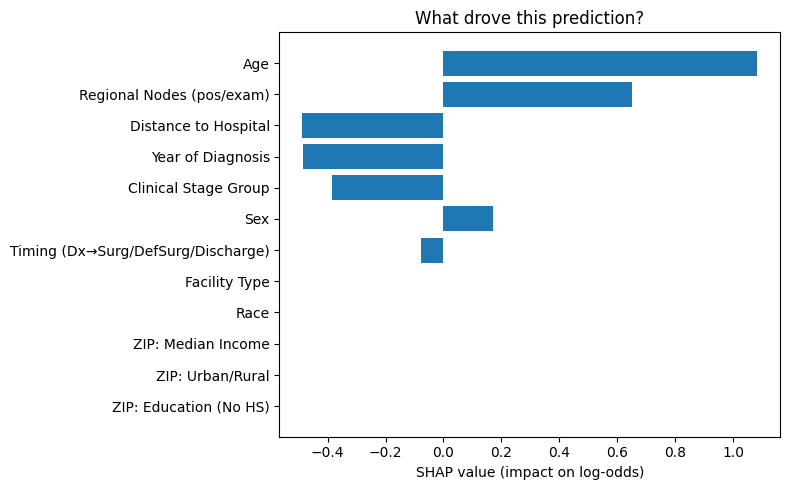

In [9]:
# Prediction backend for probability of 30d mortality after surgery for HNSCC with ONM

# ------------------------------- #
# Inference function (Gradio backend)
# ------------------------------- #

def build_feature_row_from_inputs(
    zip_code: str,
    year_of_dx: float,
    age: float,
    crowfly: float,
    tumor_size: float,
    pos_nodes: float,
    nodes_exam: float,
    dx_surg_days: float,
    dx_defsurg_days: float,
    surg_discharge_days: float,
    cdcc_label: str,
    behavior_label: str,
    race_label: str,
    sex_label: str,
    facility_type_label: str,
    clin_stage_label: str,
):
    # Initialize all features (zeros)
    features = {k: 0 for k in selected_features}

    # Numerics (with defaults on None/NaN)
    def _nz(x, key):  # normalize numeric input to default if blank
        return float(x) if x not in (None, "", np.nan) else default_values[key]

    features["YEAR_OF_DIAGNOSIS"]      = _nz(year_of_dx, "YEAR_OF_DIAGNOSIS")
    features["AGE"]                    = _nz(age, "AGE")
    features["CROWFLY"]                = _nz(crowfly, "CROWFLY")
    features["TUMOR_SIZE"]             = _nz(tumor_size, "TUMOR_SIZE")
    features["TUMOR_SIZE_SUMMARY_16"]  = features["TUMOR_SIZE"]  # per your spec: use same numeric value
    features["REGIONAL_NODES_POSITIVE"]= _nz(pos_nodes, "REGIONAL_NODES_POSITIVE")
    features["REGIONAL_NODES_EXAMINED"]= _nz(nodes_exam, "REGIONAL_NODES_EXAMINED")
    features["DX_SURG_STARTED_DAYS"]   = _nz(dx_surg_days, "DX_SURG_STARTED_DAYS")
    features["DX_DEFSURG_STARTED_DAYS"]= _nz(dx_defsurg_days, "DX_DEFSURG_STARTED_DAYS")
    features["SURG_DISCHARGE_DAYS"]    = _nz(surg_discharge_days, "SURG_DISCHARGE_DAYS")

    # Charlson (dropdown '0/1/2/3+'), map to int 0..3 (we’ll cap 3+ -> 3)
    cdcc_code = {"0": 0, "1": 1, "2": 2, "3+": 3}.get(str(cdcc_label), default_values["CDCC_TOTAL_BEST"])
    features["CDCC_TOTAL_BEST"] = cdcc_code

    # Behavior (0..3)
    features["BEHAVIOR"] = BEHAVIOR_UI_TO_CODE.get(behavior_label, default_values["BEHAVIOR"])

    # Race one-hot (White, Black, Other)
    for col in ("RACE_1.0", "RACE_2.0", "RACE_OTHER"):
        features[col] = 0
    for col in RACE_UI_TO_ONEHOT.get(race_label, ("RACE_OTHER",)):
        features[col] = 1

    # Sex one-hot
    for col in ("SEX_1.0", "SEX_2.0"):
        features[col] = 0
    for col in SEX_UI_TO_ONEHOT.get(sex_label, tuple()):
        features[col] = 1

    # Facility Type one-hot
    for col in ("FACILITY_TYPE_CD_1.0", "FACILITY_TYPE_CD_2.0",
                "FACILITY_TYPE_CD_3.0", "FACILITY_TYPE_CD_4.0", "FACILITY_TYPE_CD_nan"):
        features[col] = 0
    for col in FACILITY_TYPE_UI_TO_ONEHOT.get(facility_type_label, ("FACILITY_TYPE_CD_nan",)):
        features[col] = 1

    # Clinical Stage Group one-hot
    for col in [
        'TNM_CLIN_STAGE_GROUP_',
        'TNM_CLIN_STAGE_GROUP_   0',
        'TNM_CLIN_STAGE_GROUP_   1',
        'TNM_CLIN_STAGE_GROUP_   2',
        'TNM_CLIN_STAGE_GROUP_   3',
        'TNM_CLIN_STAGE_GROUP_   4',
        'TNM_CLIN_STAGE_GROUP_  4A',
        'TNM_CLIN_STAGE_GROUP_  4B',
        'TNM_CLIN_STAGE_GROUP_  4C',
        'TNM_CLIN_STAGE_GROUP_  99',
    ]:
        features[col] = 0
    # TODO: set chosen stage’s one-hot (we leave the bare 'TNM_CLIN_STAGE_GROUP_' at 0 unless you later decide to use it)
    stage_col = CLIN_STAGE_UI_TO_ONEHOT.get(clin_stage_label, None)
    if stage_col:
        features[stage_col] = 1

    # ZIP → 8 NCDB-style variables (with robust fallbacks)
    zip_defaults = {
        "NO_HSD_QUAR_00": default_values["NO_HSD_QUAR_00"],
        "NO_HSD_QUAR_12": default_values["NO_HSD_QUAR_12"],
        "NO_HSD_QUAR_2016": default_values["NO_HSD_QUAR_2016"],
        "MED_INC_QUAR_00": default_values["MED_INC_QUAR_00"],
        "MED_INC_QUAR_12": default_values["MED_INC_QUAR_12"],
        "MED_INC_QUAR_2016": default_values["MED_INC_QUAR_2016"],
        "UR_CD_03": default_values["UR_CD_03"],
        "UR_CD_13": default_values["UR_CD_13"],
    }
    try:
        zip_vars = ncdb_zip_to_vars(str(zip_code).strip())
    except Exception:
        zip_vars = zip_defaults
    for k, v in zip_vars.items():
        features[k] = int(v) if v is not None else zip_defaults[k]

    # Build DataFrame in exact training order
    df = pd.DataFrame([[features.get(col, 0) for col in selected_features]], columns=selected_features)

    return df

DEFAULT_UI = (
    "07605", 2015, 65, 10, 30, 1, 10, 14, 21, 5, "0",
    "Invasive", "White", "M", "Academic/Research Program", "Stage 1",
)

_DEFAULT_CACHE = {}  # in-memory

def warm_cache_default():
    try:
        df_row = build_feature_row_from_inputs(*DEFAULT_UI)
        p = float(stacked_model.predict_proba(df_row)[0, 1])
        or_vs_base = odds_ratio_vs_baseline(p, BASELINE_PREVALENCE)
        fig = shap_grouped_bar_kernel(stacked_model, df_row, bg_pickle_path="ONM-Outcomes/models/shap_background.pkl")

        risk_line = f"**Predicted 30-day mortality risk:** {p*100:.2f}%"
        or_line   = f"**Odds ratio vs baseline ({BASELINE_PREVALENCE*100:.2f}%):** {or_vs_base:.2f}×"
        _DEFAULT_CACHE["result"] = (risk_line, or_line, fig)
        print("[CACHE] default example warmed.")
    except Exception as e:
        print(f"[CACHE] warm failed: {e}")

# call once after model is loaded
warm_cache_default()

def predict_and_explain(*ui_inputs):
    """
    1) Build model-ready row from UI inputs
    2) Predict p(30d mortality)
    3) Compute odds ratio vs. baseline
    4) Compute grouped SHAP and return bar figure
    """
    # quick cache for the exact default example
    if ui_inputs == DEFAULT_UI and "result" in _DEFAULT_CACHE:
        return _DEFAULT_CACHE["result"]

    # 1) Build 1-row df expected by the model (use your current logic)
    df_row = build_feature_row_from_inputs(*ui_inputs)

    # 2) Probability (works for either a StackingClassifier or any calibrated final model)
    p = float(stacked_model.predict_proba(df_row)[0, 1])

    # 3) Odds ratio vs baseline
    or_vs_base = odds_ratio_vs_baseline(p, BASELINE_PREVALENCE)

    # 4) SHAP background & grouped bar
    fig = shap_grouped_bar_kernel(stacked_model, df_row, bg_pickle_path="ONM-Outcomes/models/shap_background.pkl")

    # Nicely formatted text outputs
    risk_line = f"**Predicted 30-day mortality risk:** {p*100:.2f}%"
    or_line   = f"**Odds ratio vs baseline ({BASELINE_PREVALENCE*100:.2f}%):** {or_vs_base:.2f}×"

    if ui_inputs == DEFAULT_UI:
        _DEFAULT_CACHE["result"] = risk_line, or_line, fig

    return risk_line, or_line, fig


In [ ]:
# Gradio Demo

# ------------------------------- #
# Gradio UI (with default values preselected)
# ------------------------------- #
demo = gr.Interface(
    fn=predict_and_explain,
    inputs=[
        gr.Textbox(label="ZIP code (5 digits)", value="07605"),
        gr.Number(label="Year of Diagnosis of HNSCC", value=default_values["YEAR_OF_DIAGNOSIS"]),
        gr.Number(label="Age", value=default_values["AGE"]),
        gr.Number(label="Residence Distance to Nearest Hospital (miles)", value=default_values["CROWFLY"]),
        gr.Number(label="Tumor Size (nearest mm)", value=default_values["TUMOR_SIZE"]),
        gr.Number(label="Number of Positive Regional Nodes", value=default_values["REGIONAL_NODES_POSITIVE"]),
        gr.Number(label="Number of Regional Nodes Examined", value=default_values["REGIONAL_NODES_EXAMINED"]),
        gr.Number(label="Days from Diagnosis to First Surgery", value=default_values["DX_SURG_STARTED_DAYS"]),
        gr.Number(label="Days from Diagnosis to Definitive Surgery", value=default_values["DX_DEFSURG_STARTED_DAYS"]),
        gr.Number(label="Days from Surgery to Discharge", value=default_values["SURG_DISCHARGE_DAYS"]),

        gr.Dropdown(choices=["0", "1", "2", "3+"], value="0",
                    label="Charlson/Deyo Comorbidity Score"),
        gr.Dropdown(choices=list(BEHAVIOR_UI_TO_CODE.keys()), value="Invasive",
                    label="Behavior of tumor"),
        gr.Dropdown(choices=["White", "Black", "Other"], value="White",
                    label="Race"),
        gr.Dropdown(choices=list(SEX_UI_TO_ONEHOT.keys()), value="M",
                    label="Sex"),
        gr.Dropdown(choices=list(FACILITY_TYPE_UI_TO_ONEHOT.keys()), value="Academic/Research Program",
                    label="Facility Type"),
        gr.Dropdown(choices=list(CLIN_STAGE_UI_TO_ONEHOT.keys()), value="Stage 1",
                    label="Clinical Stage Group"),
    ],
    outputs=[
        gr.Markdown(label="Risk"),
        gr.Markdown(label="Odds Ratio vs Baseline"),
        gr.Plot(label="Local Explanation (Grouped SHAP)"),
    ],
    title="30-Day Mortality Risk Predictor (HNSCC, ONM)",
    description=(
        "Predict risk of 30-Day Mortality Using Ensemble Machine Learning Model"
        "Trained on National Cancer Database"
    ),
    allow_flagging="never",
)

demo.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:414: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a8ba2f8c6cf6bb624a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
